# Cluster optimization

This tutorial shows how to optimize clustering parameters.


In [1]:
# Prerequisites
from toad import TOAD
from sklearn.cluster import HDBSCAN  # type: ignore
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

/Users/jakobharteg/miniconda3/envs/toad312/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# start by initiating TOAD
td = TOAD("test_data/garbe_2020_antarctica.nc", time_dim="GMST")
td.data = td.data.coarsen(x=3, y=3, GMST=3, boundary="trim").reduce(np.mean)
td.data = td.data.drop_vars(td.cluster_vars)

## Basic optimization

The code below performs parameter optimization for HDBSCAN clustering. It runs 50 trials to find optimal values for `shift_threshold` (0.6-0.95) and `time_scale_factor` (0.5-1.5), while keeping `min_cluster_size` fixed at 10. The optimization uses the `combined_spatial_nonlinearity` objective function, which balances spatial autocorrelation and nonlinearity of the clusters.

Currently built-in objective functions are:

- median_heaviside
- mean_heaviside
- mean_consistency
- mean_spatial_autocorrelation
- mean_nonlinearity
- combined_spatial_nonlinearity


In [3]:
td.compute_clusters(
    var="thk",
    method=HDBSCAN,
    optimize=True,
    optimization_params={
        "min_cluster_size": 10,  # fixed value
        "shift_threshold": (0.6, 0.95),  # lower and upper bounds
        "time_scale_factor": (0.5, 1.5),
    },
    objective="combined_spatial_nonlinearity",
    n_trials=50,
)

INFO: optimizing 50 trials with params: {'min_cluster_size': 10, 'shift_threshold': (0.6, 0.95), 'time_scale_factor': (0.5, 1.5)}


  0%|          | 0/50 [00:00<?, ?it/s]

ERROR: Failed to normalise by max = 0.0
INFO: Ran 50 trials in 4.51 seconds. Best (#17): score 0.5303, params {'shift_threshold': 0.9497304805605471, 'time_scale_factor': 0.6889961674435331}. 
INFO: New cluster variable thk_dts_cluster: Identified 11 clusters in 607 pts; Left 3.5% as noise (21 pts).



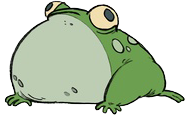

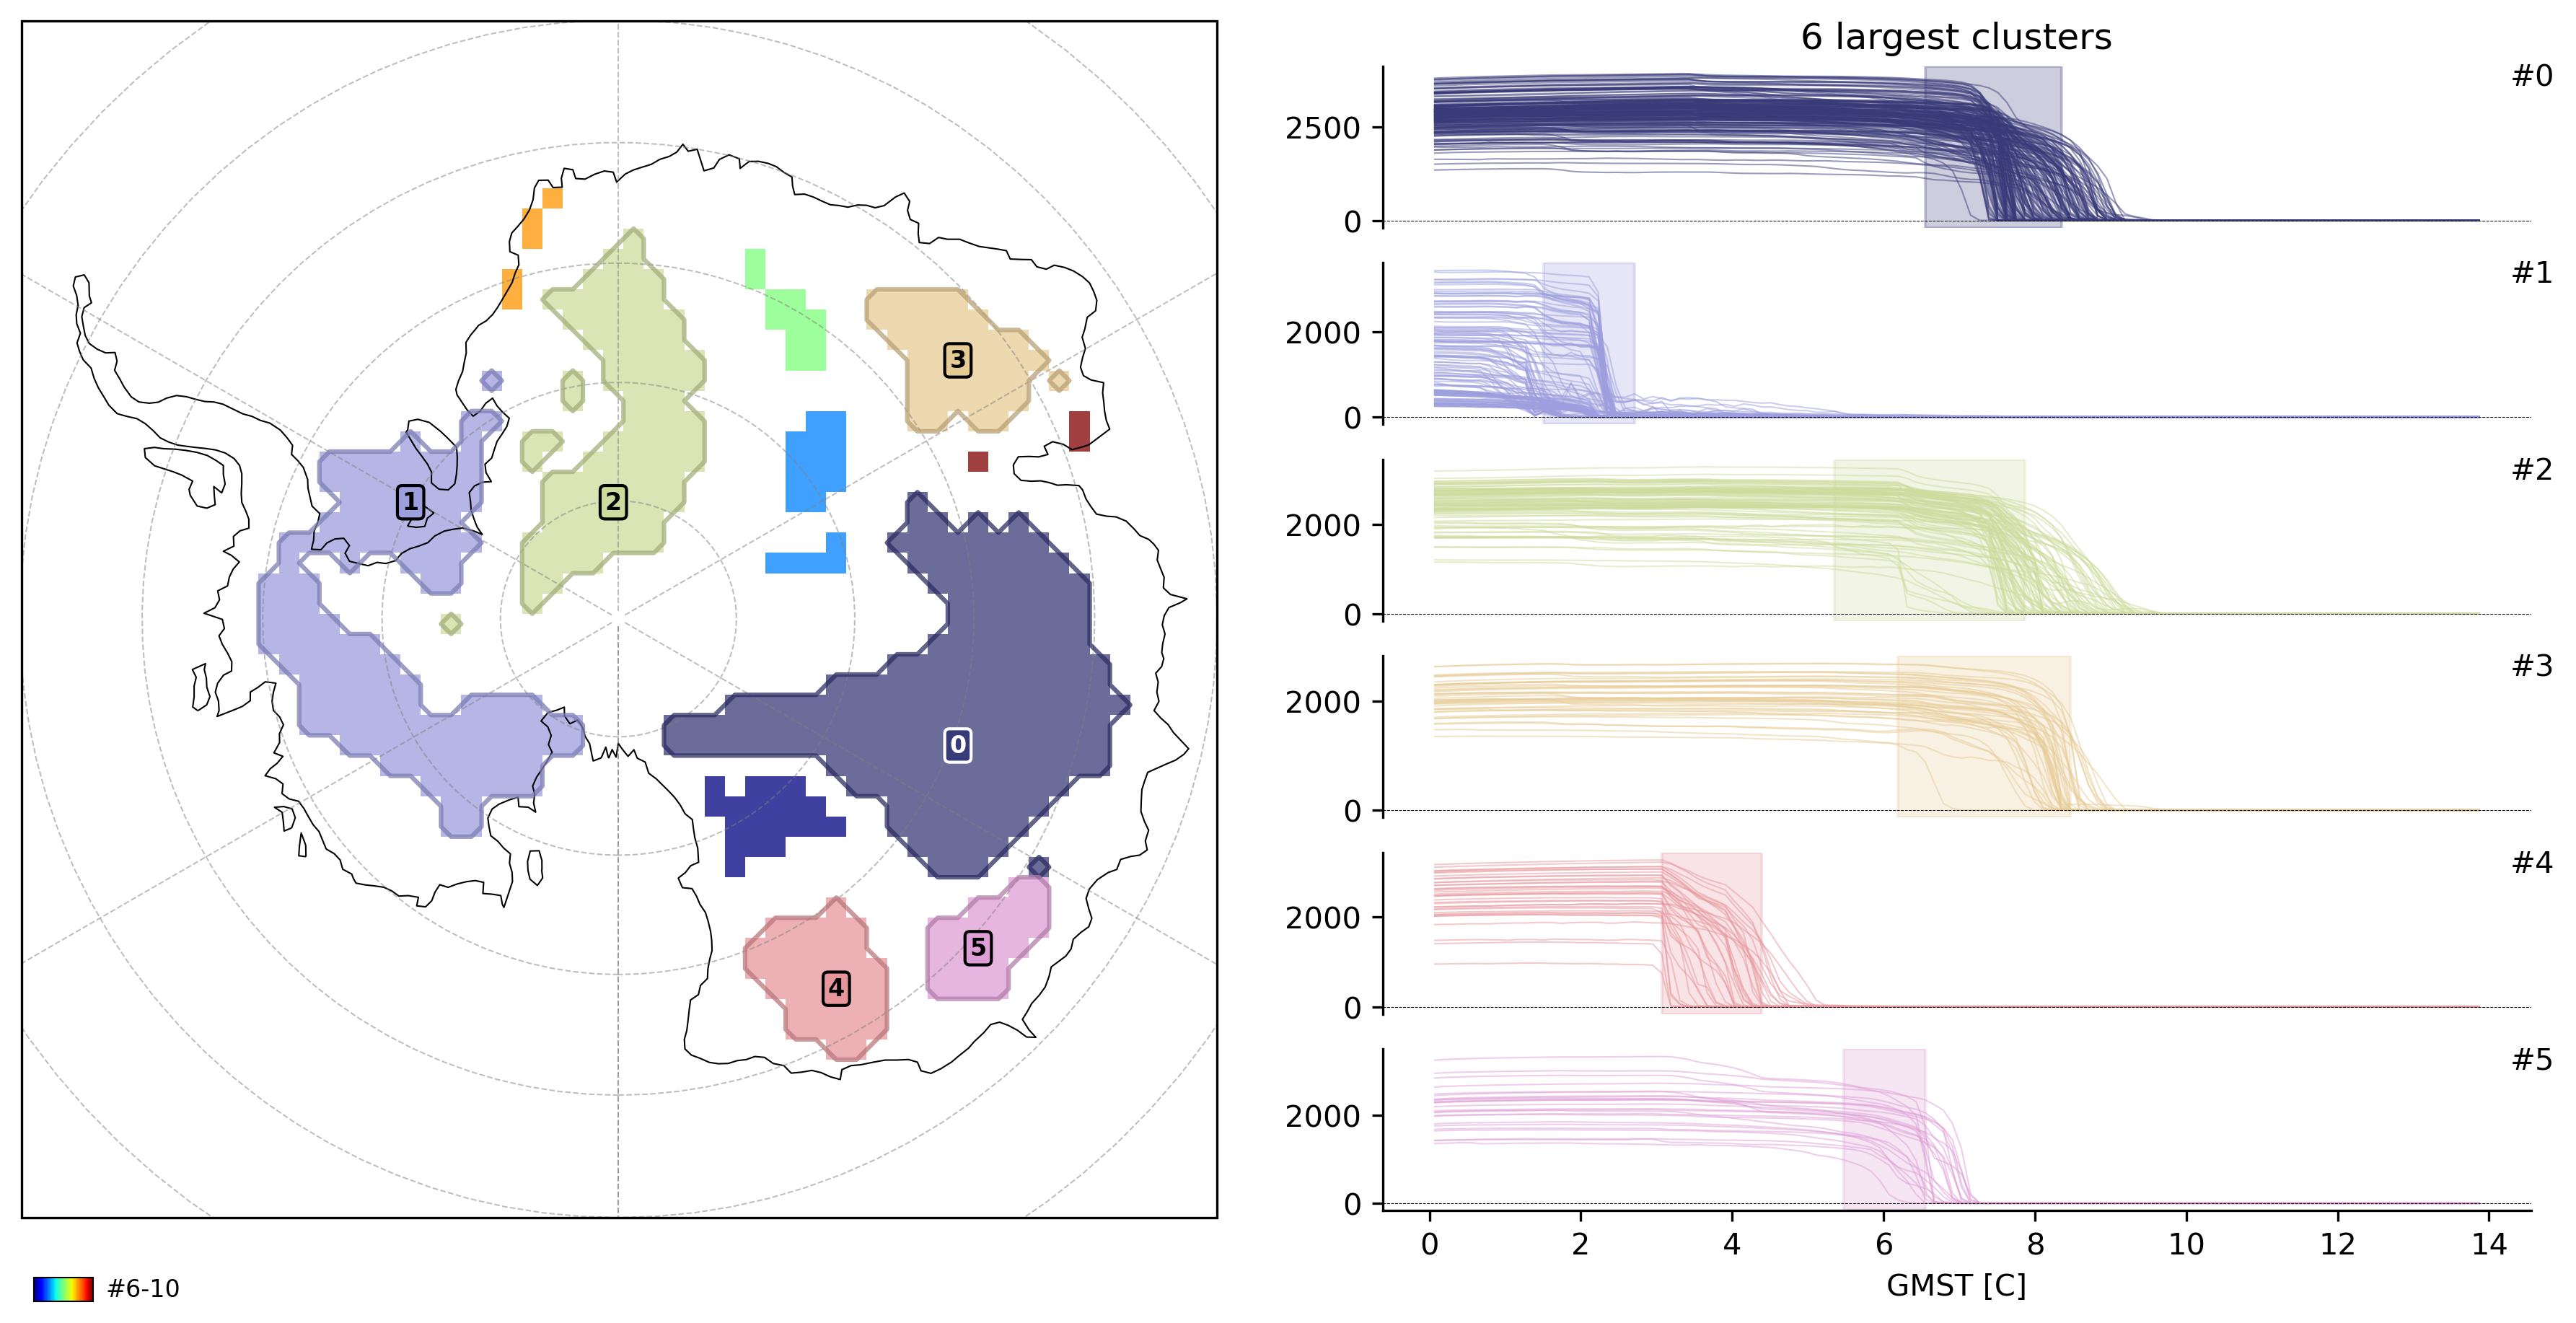

In [4]:
# Once the optimization finished, the best solution is saved in the TOAD instance and we can plot the results:
td.plot.overview("thk", map_style={"projection": "south_pole"})
td

## Defining your own optimization function

You can also define your own objective function:


In [5]:
# Define objective function
def custom_objective_func(td, cluster_variable) -> float:
    """In here you have access to the TOAD object after each computation and the variable name"""

    # Example of how one could compute a score using the cluster_stats object.
    # Specifically: we compute the median spatial autocorrelation of the two largest clusters.
    cluster_ids = td.get_cluster_ids(cluster_variable)
    score = td.stats(cluster_variable).general.aggregate_cluster_scores(
        cluster_ids=cluster_ids[:2],
        score_method="score_spatial_autocorrelation",
        aggregation="median",
    )

    # must return a float
    return float(score)


# Run optimization
td.compute_clusters(
    var="thk",
    method=HDBSCAN,
    optimize=True,
    optimization_params={
        "min_cluster_size": (8, 25),
    },
    objective=custom_objective_func,  # pass the function to the optimization routine
    direction="maximize",  # higher is better so set direction to "maximize"
    n_trials=10,
)

INFO: optimizing 10 trials with params: {'min_cluster_size': (8, 25)}


  0%|          | 0/10 [00:00<?, ?it/s]

INFO: Ran 10 trials in 0.38 seconds. Best (#0): score 0.1362, params {'min_cluster_size': 10}. 
INFO: New cluster variable thk_dts_cluster_1: Identified 15 clusters in 1,466 pts; Left 28.1% as noise (412 pts).


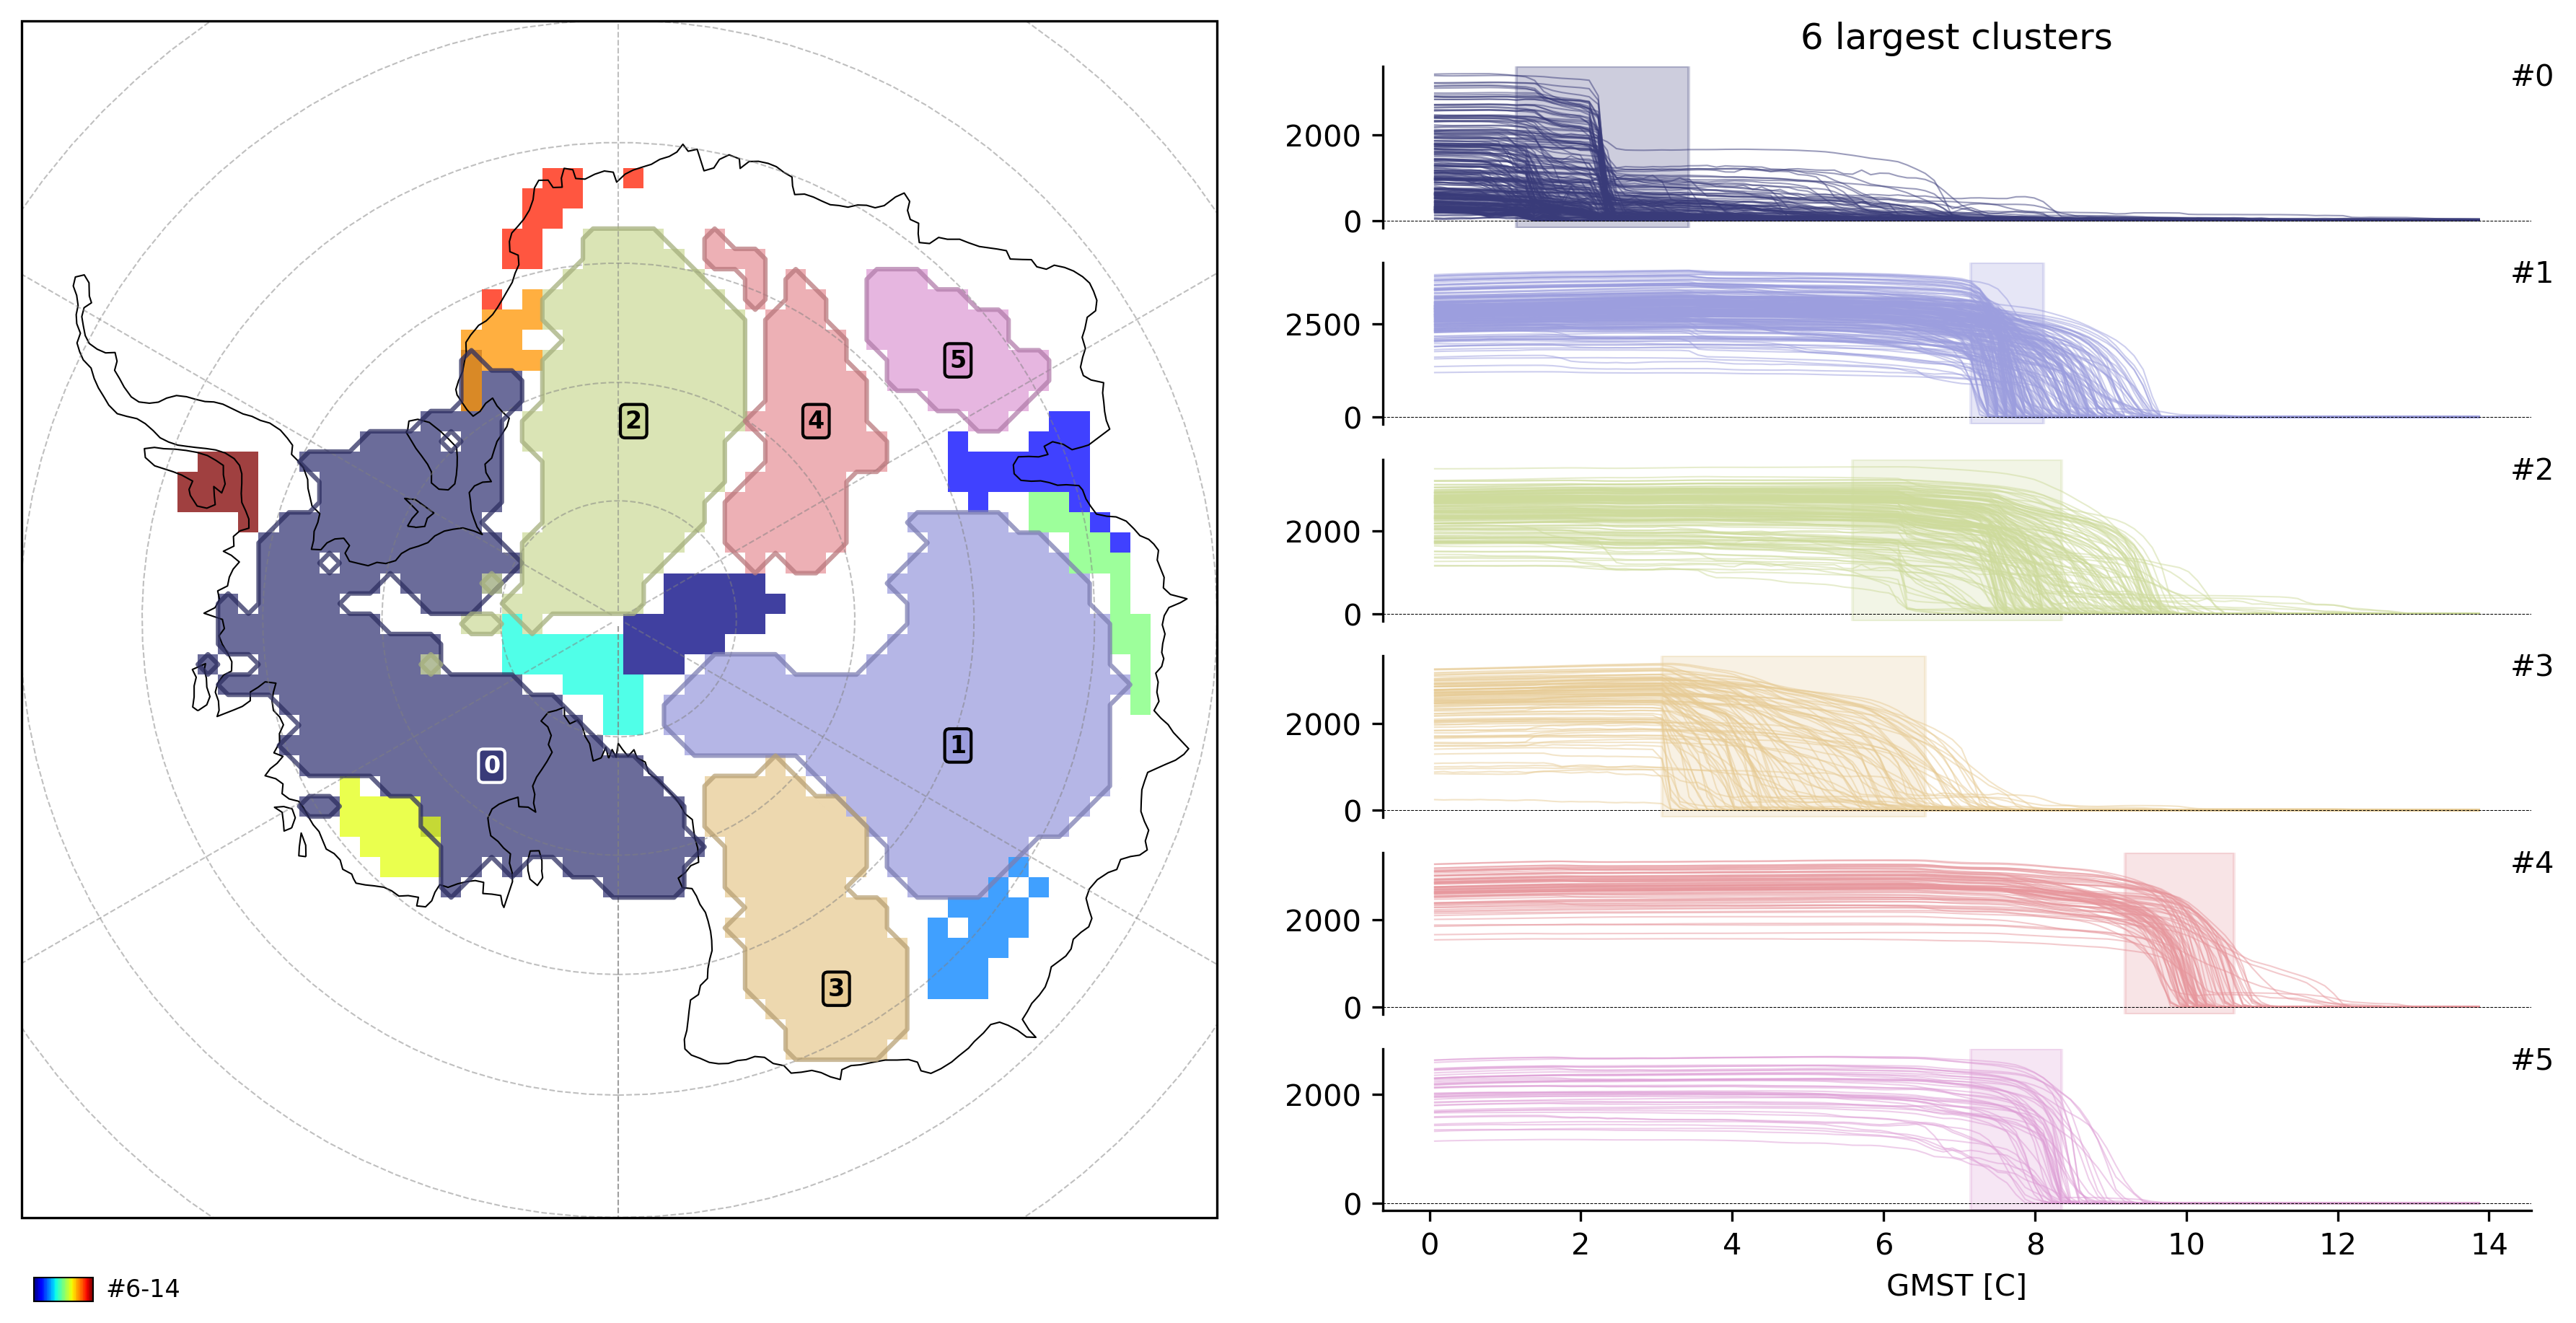

In [6]:
# plot the latest cluster variable
td.plot.overview(td.cluster_vars[-1], map_style={"projection": "south_pole"});